# Imports and Exploration

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


Using device: cuda
Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9912422/9912422 [00:11<00:00, 899113.73it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28881/28881 [00:00<00:00, 134781.66it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1648877/1648877 [00:01<00:00, 1266043.90it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4542/4542 [00:00<00:00, 5004079.00it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



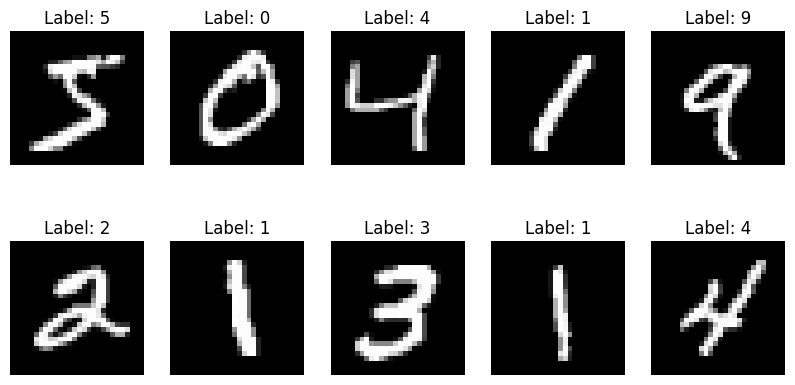

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Function to display images
def show_mnist_images(dataset, num_images=10):
    plt.figure(figsize=(10, 5))
    for i in range(num_images):
        image, label = dataset[i]
        image = image.squeeze()  # Remove channel dimension
        plt.subplot(2, num_images//2, i + 1)  # Create a subplot
        plt.imshow(image, cmap='gray')
        plt.title(f'Label: {label}')
        plt.axis('off')
    plt.show()

# Show 10 images from the training set
show_mnist_images(trainset, num_images=10)


#Question 1

In [ ]:
train_size = int(0.7 * len(trainset))
val_size = len(trainset) - train_size
train_data, val_data = torch.utils.data.random_split(trainset, [train_size, val_size])


trainloader = DataLoader(train_data, batch_size=64, shuffle=True)
valloader = DataLoader(val_data, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

# or we could do this to have 70% train, 10% val, 20% test:
# # Load the original trainset (includes both train and validation data)
# full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# # Calculate dataset sizes based on percentages
# train_size = int(0.7 * len(full_dataset))
# val_size = int(0.1 * len(full_dataset))
# test_size = len(full_dataset) - train_size - val_size

# # Split the dataset into train, val, and test
# train_data, val_data, test_data = random_split(full_dataset, [train_size, val_size, test_size])

# # Create DataLoaders
# trainloader = DataLoader(train_data, batch_size=64, shuffle=True)
# valloader = DataLoader(val_data, batch_size=64, shuffle=False)
# testloader = DataLoader(test_data, batch_size=64, shuffle=False)



In [ ]:
def train(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0
    all_preds, all_labels = [], []
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    return running_loss / len(loader), f1

# Evaluate the model on the test set and generate a confusion matrix
def test(model, loader):
    model.eval()
    correct = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / len(loader.dataset)
    conf_matrix = confusion_matrix(all_labels, all_preds)
    return accuracy, conf_matrix

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0
    correct = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1 = f1_score(all_labels, all_preds, average='weighted')
    accuracy = correct / len(loader.dataset)
    return running_loss / len(loader), accuracy, f1

def plot_confusion_matrix(conf_matrix, classes):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
class MLP(nn.Module):
    def __init__(self, activation='relu', init_method=None, input_size=28*28, hidden_size=128, output_size=10):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

        if init_method == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
        elif init_method == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        else:
            nn.init.uniform_(self.fc1.weight, -0.05, 0.05)
            nn.init.uniform_(self.fc2.weight, -0.05, 0.05)

        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)  # No activation for output layer since we use CrossEntropyLoss
        return x


Epoch 1/25.. Train loss: 0.442.. Val loss: 0.273.. Val accuracy: 0.921.. Train F1: 0.875.. Val F1: 0.921
Epoch 2/25.. Train loss: 0.230.. Val loss: 0.210.. Val accuracy: 0.936.. Train F1: 0.933.. Val F1: 0.936
Epoch 3/25.. Train loss: 0.169.. Val loss: 0.175.. Val accuracy: 0.949.. Train F1: 0.950.. Val F1: 0.948
Epoch 4/25.. Train loss: 0.135.. Val loss: 0.139.. Val accuracy: 0.959.. Train F1: 0.960.. Val F1: 0.959
Epoch 5/25.. Train loss: 0.112.. Val loss: 0.129.. Val accuracy: 0.961.. Train F1: 0.966.. Val F1: 0.961
Epoch 6/25.. Train loss: 0.094.. Val loss: 0.111.. Val accuracy: 0.967.. Train F1: 0.972.. Val F1: 0.967
Epoch 7/25.. Train loss: 0.085.. Val loss: 0.121.. Val accuracy: 0.963.. Train F1: 0.973.. Val F1: 0.963
Epoch 8/25.. Train loss: 0.075.. Val loss: 0.107.. Val accuracy: 0.967.. Train F1: 0.977.. Val F1: 0.967
Epoch 9/25.. Train loss: 0.064.. Val loss: 0.105.. Val accuracy: 0.969.. Train F1: 0.980.. Val F1: 0.969
Epoch 10/25.. Train loss: 0.059.. Val loss: 0.102.. Val

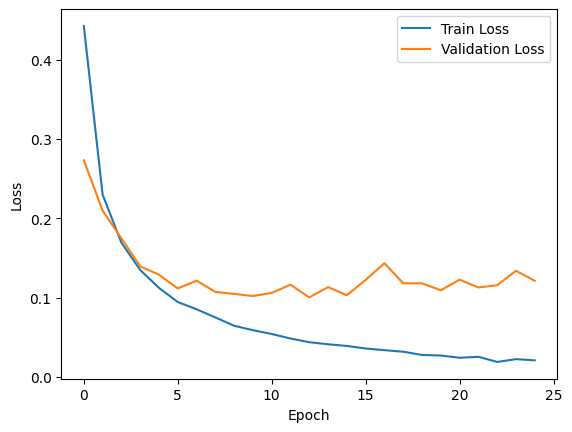

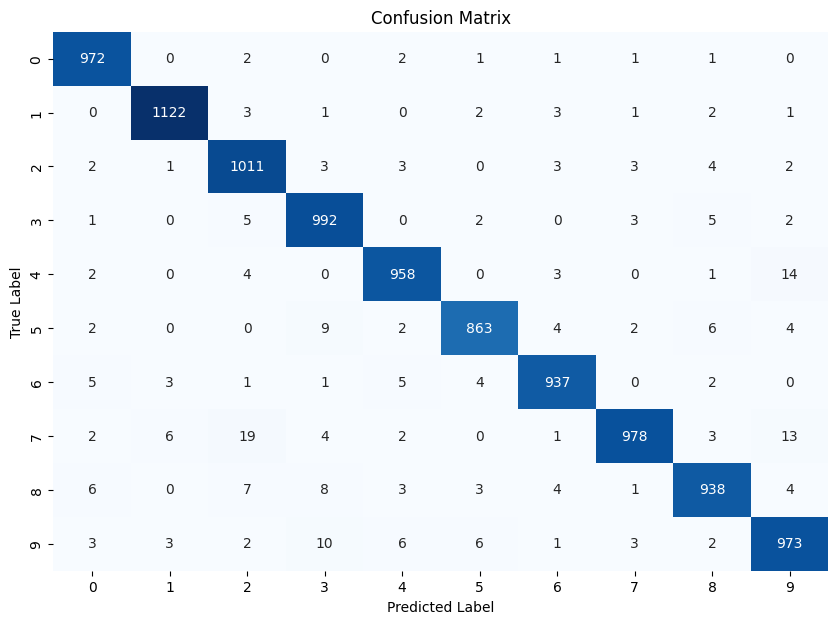

In [ ]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

epochs = 25
train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    train_loss, train_f1 = train(model, trainloader, optimizer_adam, criterion)
    val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {val_acc:.3f}.. "
          f"Train F1: {train_f1:.3f}.. "
          f"Val F1: {val_f1:.3f}")


test_accuracy, test_conf_matrix = test(model, testloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# List of class labels for MNIST
classes = [str(i) for i in range(10)]
plot_confusion_matrix(test_conf_matrix, classes)


# Question 2

In [ ]:
class MLP1(nn.Module):
    def __init__(self, activation='relu', init_method=None, input_size=28*28, hidden_size=128, output_size=10):
        super(MLP1, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

        if init_method == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
        elif init_method == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        else:
            nn.init.uniform_(self.fc1.weight, -0.05, 0.05)
            nn.init.uniform_(self.fc2.weight, -0.05, 0.05)

        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)  # No activation for output layer since we use CrossEntropyLoss
        return x

Epoch 1/10.. Train loss: 0.439.. Val loss: 0.277.. Val accuracy: 0.918.. Train F1: 0.874.. Val F1: 0.918
Epoch 2/10.. Train loss: 0.234.. Val loss: 0.219.. Val accuracy: 0.934.. Train F1: 0.931.. Val F1: 0.933
Epoch 3/10.. Train loss: 0.172.. Val loss: 0.171.. Val accuracy: 0.947.. Train F1: 0.950.. Val F1: 0.946
Epoch 4/10.. Train loss: 0.136.. Val loss: 0.148.. Val accuracy: 0.954.. Train F1: 0.959.. Val F1: 0.954
Epoch 5/10.. Train loss: 0.117.. Val loss: 0.130.. Val accuracy: 0.962.. Train F1: 0.965.. Val F1: 0.962
Epoch 6/10.. Train loss: 0.098.. Val loss: 0.125.. Val accuracy: 0.962.. Train F1: 0.970.. Val F1: 0.962
Epoch 7/10.. Train loss: 0.090.. Val loss: 0.117.. Val accuracy: 0.965.. Train F1: 0.973.. Val F1: 0.965
Epoch 8/10.. Train loss: 0.076.. Val loss: 0.117.. Val accuracy: 0.965.. Train F1: 0.976.. Val F1: 0.965
Epoch 9/10.. Train loss: 0.067.. Val loss: 0.109.. Val accuracy: 0.968.. Train F1: 0.979.. Val F1: 0.968
Epoch 10/10.. Train loss: 0.064.. Val loss: 0.114.. Val

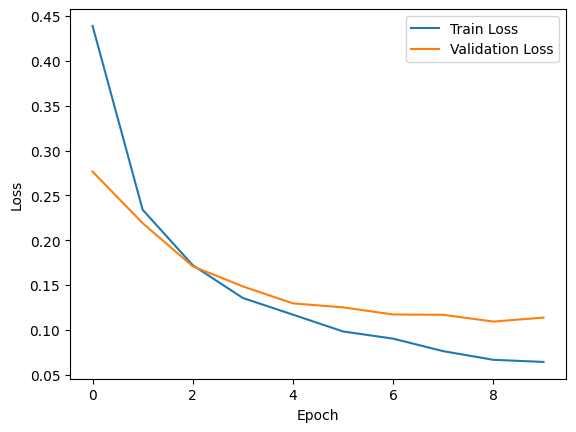

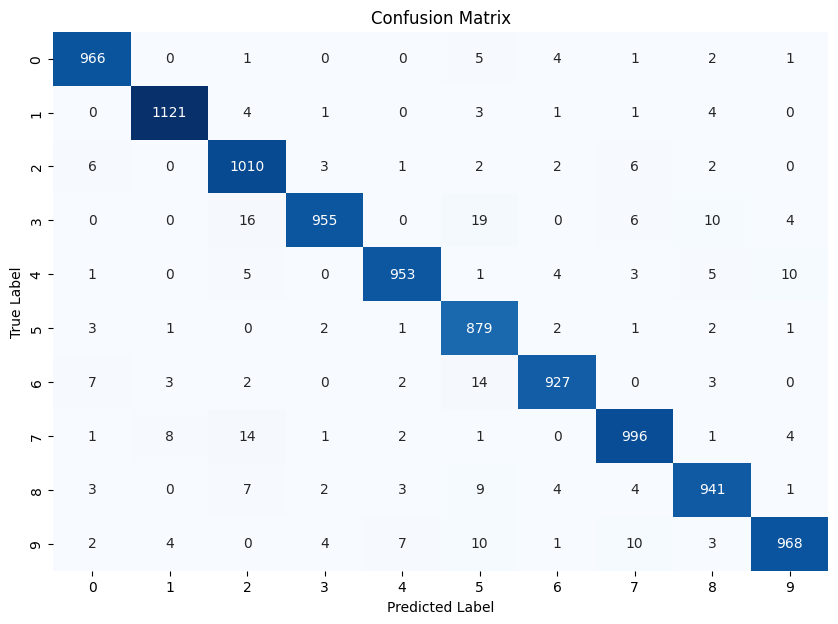

In [ ]:
model = MLP1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    train_loss, train_f1 = train(model, trainloader, optimizer_adam, criterion)
    val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {val_acc:.3f}.. "
          f"Train F1: {train_f1:.3f}.. "
          f"Val F1: {val_f1:.3f}")


test_accuracy, test_conf_matrix = test(model, testloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# List of class labels for MNIST
classes = [str(i) for i in range(10)]
plot_confusion_matrix(test_conf_matrix, classes)


In [ ]:
class MLP2(nn.Module):
    def __init__(self, activation='relu', init_method=None, input_size=28*28, hidden_size=192, output_size=10):
        super(MLP2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

        if init_method == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
        elif init_method == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        else:
            nn.init.uniform_(self.fc1.weight, -0.05, 0.05)
            nn.init.uniform_(self.fc2.weight, -0.05, 0.05)

        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)  # No activation for output layer since we use CrossEntropyLoss
        return x

Epoch 1/10.. Train loss: 0.428.. Val loss: 0.267.. Val accuracy: 0.922.. Train F1: 0.874.. Val F1: 0.922
Epoch 2/10.. Train loss: 0.217.. Val loss: 0.187.. Val accuracy: 0.944.. Train F1: 0.936.. Val F1: 0.945
Epoch 3/10.. Train loss: 0.152.. Val loss: 0.147.. Val accuracy: 0.956.. Train F1: 0.956.. Val F1: 0.956
Epoch 4/10.. Train loss: 0.122.. Val loss: 0.137.. Val accuracy: 0.958.. Train F1: 0.964.. Val F1: 0.958
Epoch 5/10.. Train loss: 0.101.. Val loss: 0.132.. Val accuracy: 0.960.. Train F1: 0.971.. Val F1: 0.960
Epoch 6/10.. Train loss: 0.086.. Val loss: 0.107.. Val accuracy: 0.967.. Train F1: 0.974.. Val F1: 0.967
Epoch 7/10.. Train loss: 0.076.. Val loss: 0.116.. Val accuracy: 0.965.. Train F1: 0.976.. Val F1: 0.965
Epoch 8/10.. Train loss: 0.068.. Val loss: 0.111.. Val accuracy: 0.966.. Train F1: 0.979.. Val F1: 0.966
Epoch 9/10.. Train loss: 0.060.. Val loss: 0.112.. Val accuracy: 0.967.. Train F1: 0.981.. Val F1: 0.967
Epoch 10/10.. Train loss: 0.056.. Val loss: 0.111.. Val

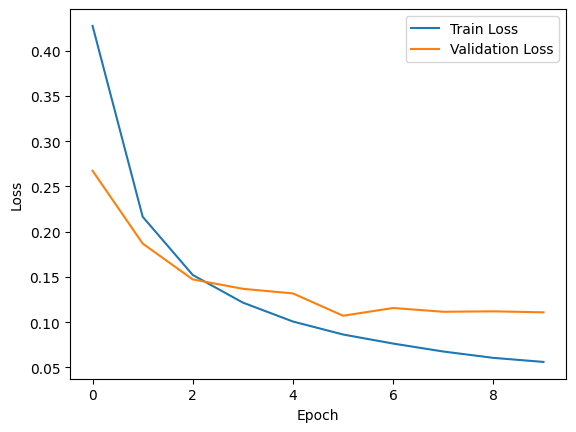

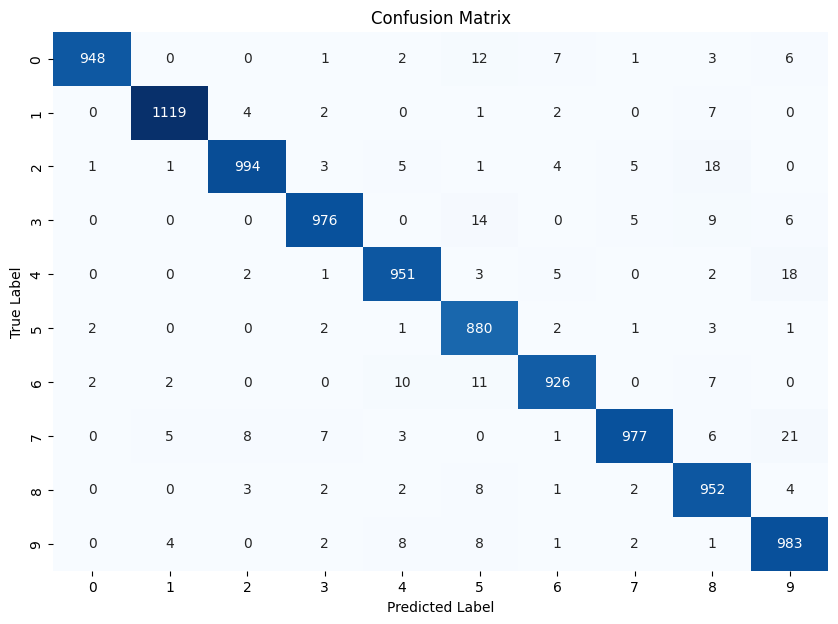

In [ ]:
model = MLP2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    train_loss, train_f1 = train(model, trainloader, optimizer_adam, criterion)
    val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {val_acc:.3f}.. "
          f"Train F1: {train_f1:.3f}.. "
          f"Val F1: {val_f1:.3f}")


test_accuracy, test_conf_matrix = test(model, testloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# List of class labels for MNIST
classes = [str(i) for i in range(10)]
plot_confusion_matrix(test_conf_matrix, classes)


In [ ]:
class MLP3(nn.Module):
    def __init__(self, activation='relu', init_method=None, input_size=28*28, hidden_size=256, output_size=10):
        super(MLP3, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

        if init_method == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
        elif init_method == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        else:
            nn.init.uniform_(self.fc1.weight, -0.05, 0.05)
            nn.init.uniform_(self.fc2.weight, -0.05, 0.05)

        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)  # No activation for output layer since we use CrossEntropyLoss
        return x

Epoch 1/10.. Train loss: 0.387.. Val loss: 0.235.. Val accuracy: 0.930.. Train F1: 0.886.. Val F1: 0.929
Epoch 2/10.. Train loss: 0.192.. Val loss: 0.189.. Val accuracy: 0.943.. Train F1: 0.943.. Val F1: 0.943
Epoch 3/10.. Train loss: 0.135.. Val loss: 0.154.. Val accuracy: 0.952.. Train F1: 0.960.. Val F1: 0.953
Epoch 4/10.. Train loss: 0.109.. Val loss: 0.115.. Val accuracy: 0.965.. Train F1: 0.967.. Val F1: 0.964
Epoch 5/10.. Train loss: 0.090.. Val loss: 0.114.. Val accuracy: 0.966.. Train F1: 0.972.. Val F1: 0.966
Epoch 6/10.. Train loss: 0.076.. Val loss: 0.115.. Val accuracy: 0.965.. Train F1: 0.976.. Val F1: 0.965
Epoch 7/10.. Train loss: 0.066.. Val loss: 0.130.. Val accuracy: 0.960.. Train F1: 0.978.. Val F1: 0.960
Epoch 8/10.. Train loss: 0.063.. Val loss: 0.107.. Val accuracy: 0.967.. Train F1: 0.980.. Val F1: 0.967
Epoch 9/10.. Train loss: 0.051.. Val loss: 0.124.. Val accuracy: 0.964.. Train F1: 0.983.. Val F1: 0.964
Epoch 10/10.. Train loss: 0.047.. Val loss: 0.100.. Val

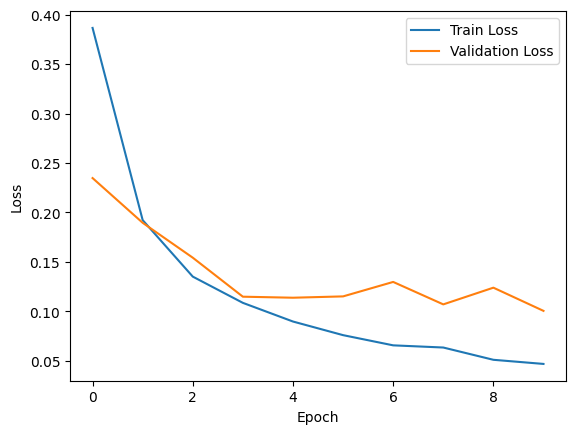

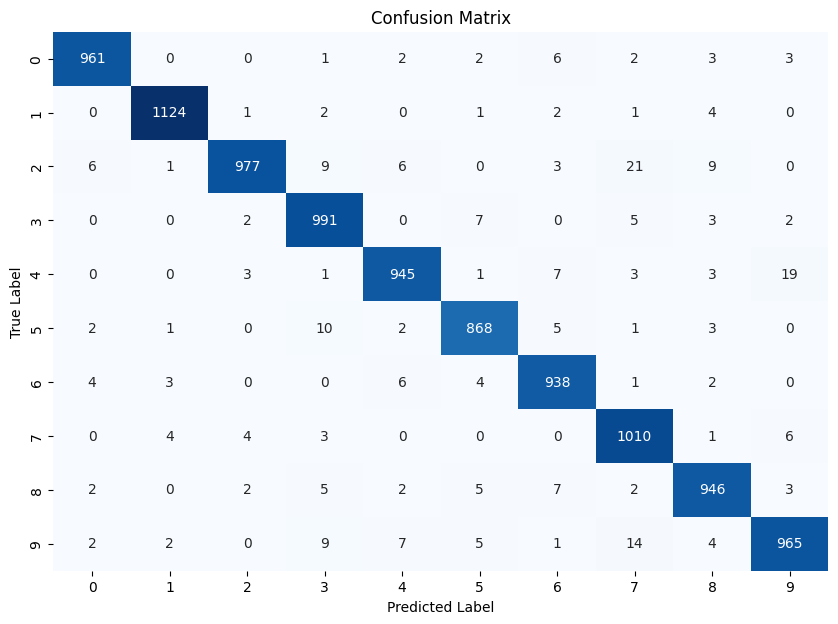

In [ ]:
model = MLP3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    train_loss, train_f1 = train(model, trainloader, optimizer_adam, criterion)
    val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {val_acc:.3f}.. "
          f"Train F1: {train_f1:.3f}.. "
          f"Val F1: {val_f1:.3f}")


test_accuracy, test_conf_matrix = test(model, testloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# List of class labels for MNIST
classes = [str(i) for i in range(10)]
plot_confusion_matrix(test_conf_matrix, classes)


In [ ]:
class MLP4(nn.Module):
    def __init__(self, activation='relu', init_method=None, input_size=28*28, hidden_size1=128, hidden_size2=96, output_size=10):
        super(MLP4, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, output_size)

        if init_method == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
        elif init_method == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
        else:
            nn.init.uniform_(self.fc1.weight, -0.05, 0.05)
            nn.init.uniform_(self.fc2.weight, -0.05, 0.05)
            nn.init.uniform_(self.fc3.weight, -0.05, 0.05)

        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)  # No activation for output layer since we use CrossEntropyLoss
        return x

Epoch 1/10.. Train loss: 0.498.. Val loss: 0.286.. Val accuracy: 0.911.. Train F1: 0.847.. Val F1: 0.911
Epoch 2/10.. Train loss: 0.240.. Val loss: 0.208.. Val accuracy: 0.937.. Train F1: 0.926.. Val F1: 0.937
Epoch 3/10.. Train loss: 0.172.. Val loss: 0.170.. Val accuracy: 0.949.. Train F1: 0.947.. Val F1: 0.949
Epoch 4/10.. Train loss: 0.140.. Val loss: 0.171.. Val accuracy: 0.949.. Train F1: 0.957.. Val F1: 0.949
Epoch 5/10.. Train loss: 0.114.. Val loss: 0.144.. Val accuracy: 0.956.. Train F1: 0.965.. Val F1: 0.956
Epoch 6/10.. Train loss: 0.100.. Val loss: 0.136.. Val accuracy: 0.959.. Train F1: 0.969.. Val F1: 0.959
Epoch 7/10.. Train loss: 0.085.. Val loss: 0.118.. Val accuracy: 0.964.. Train F1: 0.973.. Val F1: 0.964
Epoch 8/10.. Train loss: 0.074.. Val loss: 0.122.. Val accuracy: 0.964.. Train F1: 0.976.. Val F1: 0.964
Epoch 9/10.. Train loss: 0.068.. Val loss: 0.120.. Val accuracy: 0.966.. Train F1: 0.977.. Val F1: 0.966
Epoch 10/10.. Train loss: 0.061.. Val loss: 0.116.. Val

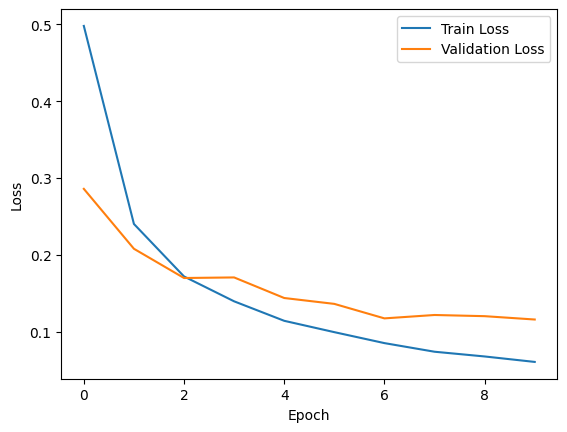

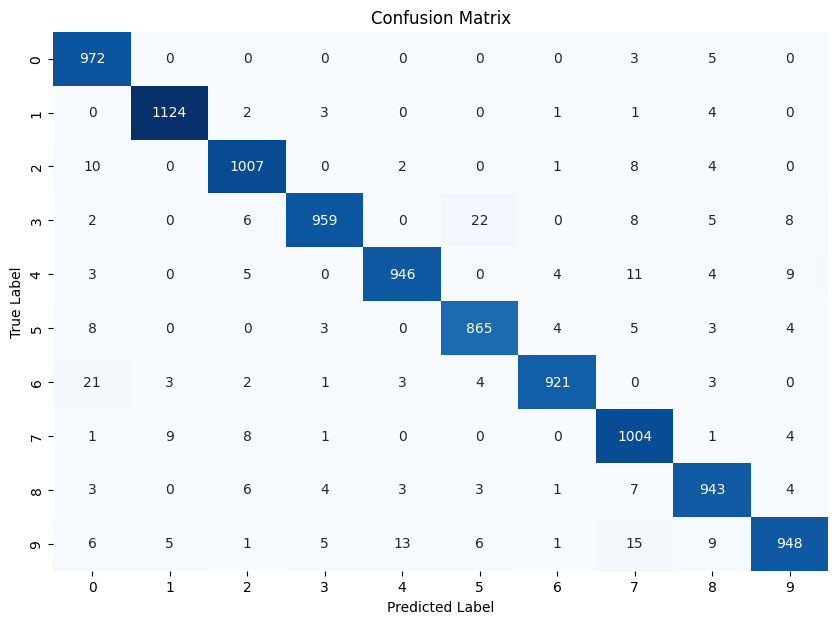

In [ ]:
model = MLP4().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    train_loss, train_f1 = train(model, trainloader, optimizer_adam, criterion)
    val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {val_acc:.3f}.. "
          f"Train F1: {train_f1:.3f}.. "
          f"Val F1: {val_f1:.3f}")


test_accuracy, test_conf_matrix = test(model, testloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# List of class labels for MNIST
classes = [str(i) for i in range(10)]
plot_confusion_matrix(test_conf_matrix, classes)


In [ ]:
class MLP5(nn.Module):
    def __init__(self, activation='relu', init_method=None, input_size=28*28, hidden_size1=128, hidden_size2=96, hidden_size3=64, output_size=10):
        super(MLP5, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)

        if init_method == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
            nn.init.xavier_uniform_(self.fc4.weight)
        elif init_method == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc4.weight, nonlinearity='relu')
        else:
            nn.init.uniform_(self.fc1.weight, -0.05, 0.05)
            nn.init.uniform_(self.fc2.weight, -0.05, 0.05)
            nn.init.uniform_(self.fc3.weight, -0.05, 0.05)
            nn.init.uniform_(self.fc4.weight, -0.05, 0.05)

        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)  # No activation for output layer since we use CrossEntropyLoss
        return x

Epoch 1/10.. Train loss: 0.568.. Val loss: 0.319.. Val accuracy: 0.905.. Train F1: 0.816.. Val F1: 0.904
Epoch 2/10.. Train loss: 0.257.. Val loss: 0.234.. Val accuracy: 0.930.. Train F1: 0.922.. Val F1: 0.930
Epoch 3/10.. Train loss: 0.184.. Val loss: 0.236.. Val accuracy: 0.929.. Train F1: 0.944.. Val F1: 0.929
Epoch 4/10.. Train loss: 0.149.. Val loss: 0.164.. Val accuracy: 0.950.. Train F1: 0.955.. Val F1: 0.950
Epoch 5/10.. Train loss: 0.125.. Val loss: 0.140.. Val accuracy: 0.958.. Train F1: 0.961.. Val F1: 0.958
Epoch 6/10.. Train loss: 0.107.. Val loss: 0.122.. Val accuracy: 0.964.. Train F1: 0.966.. Val F1: 0.964
Epoch 7/10.. Train loss: 0.093.. Val loss: 0.109.. Val accuracy: 0.968.. Train F1: 0.971.. Val F1: 0.968
Epoch 8/10.. Train loss: 0.085.. Val loss: 0.125.. Val accuracy: 0.964.. Train F1: 0.973.. Val F1: 0.964
Epoch 9/10.. Train loss: 0.074.. Val loss: 0.104.. Val accuracy: 0.969.. Train F1: 0.976.. Val F1: 0.969
Epoch 10/10.. Train loss: 0.069.. Val loss: 0.122.. Val

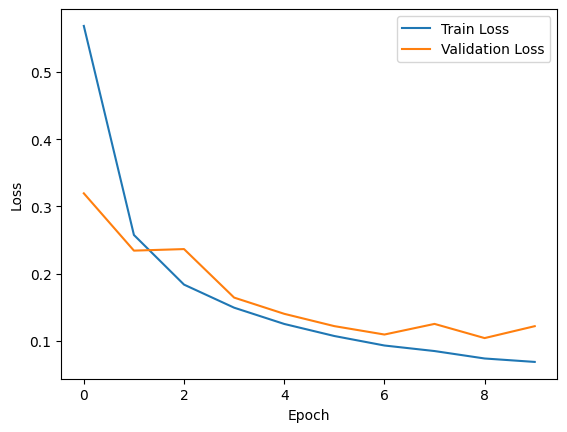

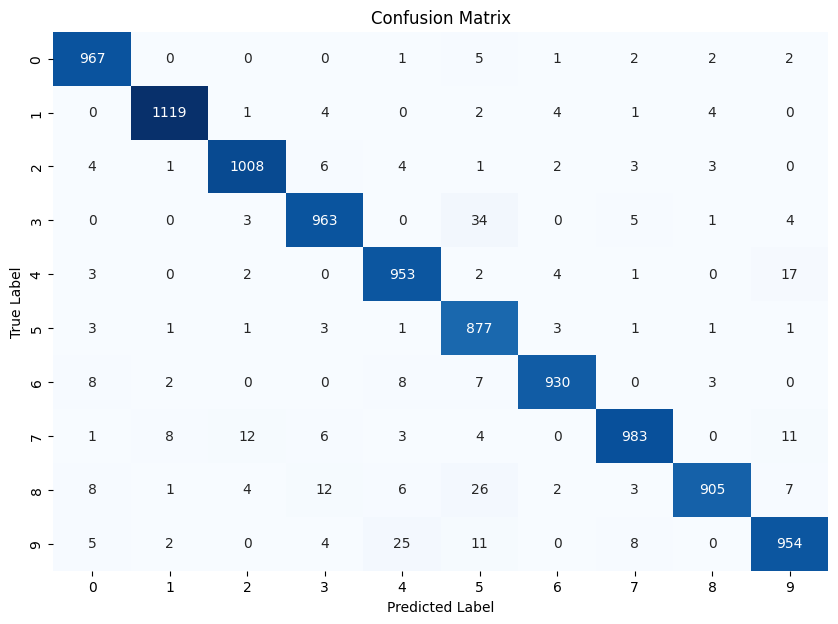

In [ ]:
model = MLP5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    train_loss, train_f1 = train(model, trainloader, optimizer_adam, criterion)
    val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {val_acc:.3f}.. "
          f"Train F1: {train_f1:.3f}.. "
          f"Val F1: {val_f1:.3f}")


test_accuracy, test_conf_matrix = test(model, testloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# List of class labels for MNIST
classes = [str(i) for i in range(10)]
plot_confusion_matrix(test_conf_matrix, classes)


In [ ]:
class MLP6(nn.Module):
    def __init__(self, activation='relu', init_method=None, input_size=28*28, hidden_size1=128, hidden_size2=96, hidden_size3=64, hidden_size4=32, output_size=10):
        super(MLP6, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.fc5 = nn.Linear(hidden_size4, output_size)

        if init_method == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
            nn.init.xavier_uniform_(self.fc3.weight)
            nn.init.xavier_uniform_(self.fc4.weight)
            nn.init.xavier_uniform_(self.fc5.weight)
        elif init_method == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc3.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc4.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc5.weight, nonlinearity='relu')
        else:
            nn.init.uniform_(self.fc1.weight, -0.05, 0.05)
            nn.init.uniform_(self.fc2.weight, -0.05, 0.05)
            nn.init.uniform_(self.fc3.weight, -0.05, 0.05)
            nn.init.uniform_(self.fc4.weight, -0.05, 0.05)
            nn.init.uniform_(self.fc5.weight, -0.05, 0.05)

        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.activation(self.fc4(x))
        x = self.fc5(x)  # No activation for output layer since we use CrossEntropyLoss
        return x

Epoch 1/10.. Train loss: 0.716.. Val loss: 0.427.. Val accuracy: 0.871.. Train F1: 0.763.. Val F1: 0.871
Epoch 2/10.. Train loss: 0.322.. Val loss: 0.260.. Val accuracy: 0.922.. Train F1: 0.905.. Val F1: 0.922
Epoch 3/10.. Train loss: 0.218.. Val loss: 0.199.. Val accuracy: 0.942.. Train F1: 0.935.. Val F1: 0.942
Epoch 4/10.. Train loss: 0.173.. Val loss: 0.181.. Val accuracy: 0.947.. Train F1: 0.948.. Val F1: 0.947
Epoch 5/10.. Train loss: 0.142.. Val loss: 0.153.. Val accuracy: 0.955.. Train F1: 0.957.. Val F1: 0.954
Epoch 6/10.. Train loss: 0.122.. Val loss: 0.147.. Val accuracy: 0.956.. Train F1: 0.963.. Val F1: 0.956
Epoch 7/10.. Train loss: 0.107.. Val loss: 0.153.. Val accuracy: 0.954.. Train F1: 0.967.. Val F1: 0.955
Epoch 8/10.. Train loss: 0.099.. Val loss: 0.121.. Val accuracy: 0.964.. Train F1: 0.969.. Val F1: 0.964
Epoch 9/10.. Train loss: 0.087.. Val loss: 0.144.. Val accuracy: 0.959.. Train F1: 0.973.. Val F1: 0.958
Epoch 10/10.. Train loss: 0.081.. Val loss: 0.139.. Val

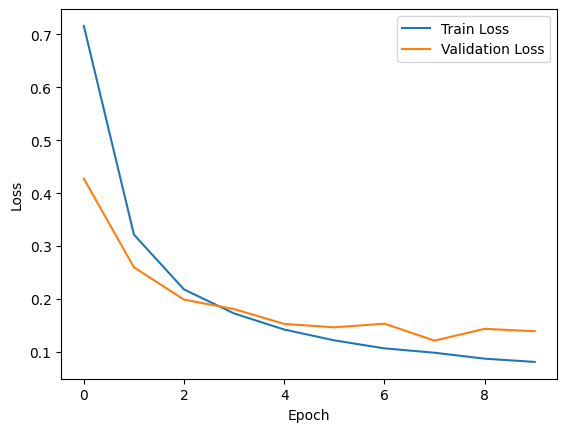

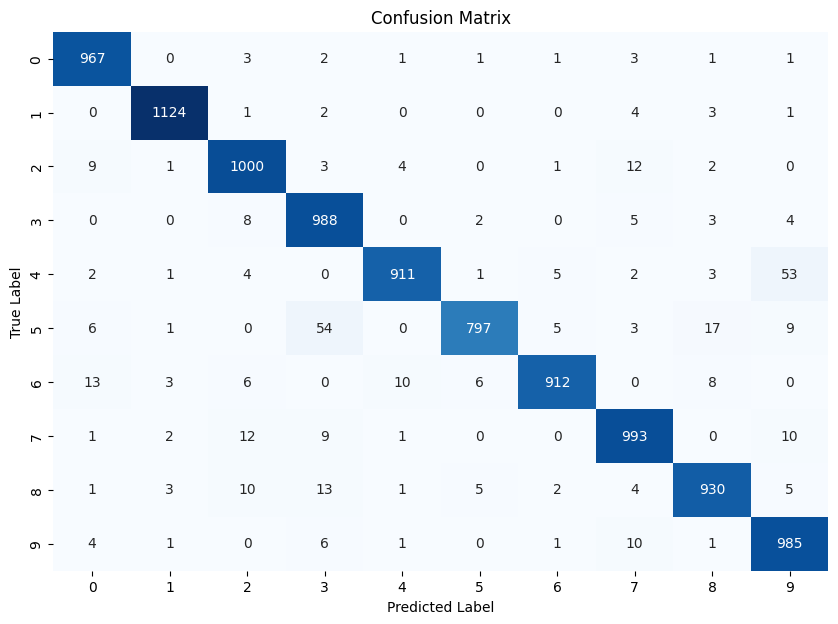

In [ ]:
model = MLP6().to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    train_loss, train_f1 = train(model, trainloader, optimizer_adam, criterion)
    val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {val_acc:.3f}.. "
          f"Train F1: {train_f1:.3f}.. "
          f"Val F1: {val_f1:.3f}")


test_accuracy, test_conf_matrix = test(model, testloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# List of class labels for MNIST
classes = [str(i) for i in range(10)]
plot_confusion_matrix(test_conf_matrix, classes)


# Question 3

Epoch 1/10.. Train loss: 0.440.. Val loss: 0.281.. Val accuracy: 0.916.. Train F1: 0.873.. Val F1: 0.916
Epoch 2/10.. Train loss: 0.231.. Val loss: 0.205.. Val accuracy: 0.942.. Train F1: 0.932.. Val F1: 0.941
Epoch 3/10.. Train loss: 0.171.. Val loss: 0.193.. Val accuracy: 0.944.. Train F1: 0.949.. Val F1: 0.944
Epoch 4/10.. Train loss: 0.135.. Val loss: 0.140.. Val accuracy: 0.959.. Train F1: 0.960.. Val F1: 0.959
Epoch 5/10.. Train loss: 0.110.. Val loss: 0.132.. Val accuracy: 0.958.. Train F1: 0.968.. Val F1: 0.958
Epoch 6/10.. Train loss: 0.095.. Val loss: 0.117.. Val accuracy: 0.964.. Train F1: 0.971.. Val F1: 0.964
Epoch 7/10.. Train loss: 0.084.. Val loss: 0.112.. Val accuracy: 0.967.. Train F1: 0.975.. Val F1: 0.967
Epoch 8/10.. Train loss: 0.074.. Val loss: 0.137.. Val accuracy: 0.957.. Train F1: 0.977.. Val F1: 0.957
Epoch 9/10.. Train loss: 0.066.. Val loss: 0.108.. Val accuracy: 0.968.. Train F1: 0.979.. Val F1: 0.968
Epoch 10/10.. Train loss: 0.060.. Val loss: 0.107.. Val

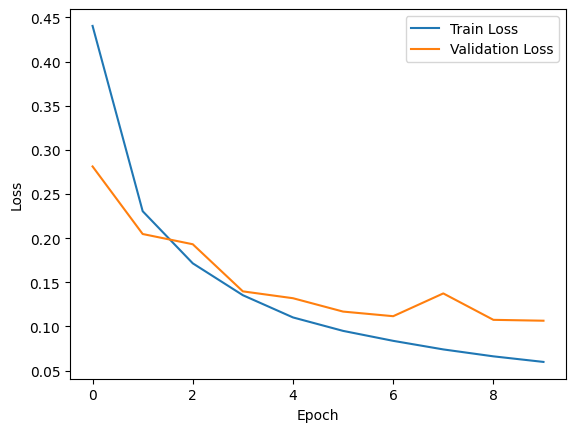

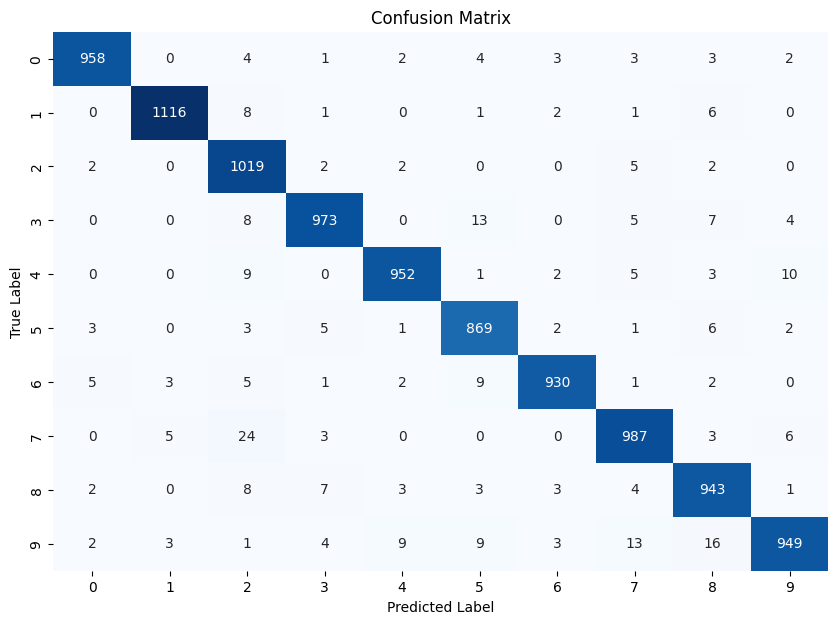

In [ ]:
model = MLP(activation='relu').to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    train_loss, train_f1 = train(model, trainloader, optimizer_adam, criterion)
    val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {val_acc:.3f}.. "
          f"Train F1: {train_f1:.3f}.. "
          f"Val F1: {val_f1:.3f}")


test_accuracy, test_conf_matrix = test(model, testloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# List of class labels for MNIST
classes = [str(i) for i in range(10)]
plot_confusion_matrix(test_conf_matrix, classes)


Epoch 1/10.. Train loss: 0.581.. Val loss: 0.315.. Val accuracy: 0.910.. Train F1: 0.859.. Val F1: 0.911
Epoch 2/10.. Train loss: 0.256.. Val loss: 0.241.. Val accuracy: 0.929.. Train F1: 0.926.. Val F1: 0.929
Epoch 3/10.. Train loss: 0.202.. Val loss: 0.201.. Val accuracy: 0.940.. Train F1: 0.943.. Val F1: 0.940
Epoch 4/10.. Train loss: 0.168.. Val loss: 0.186.. Val accuracy: 0.946.. Train F1: 0.952.. Val F1: 0.946
Epoch 5/10.. Train loss: 0.142.. Val loss: 0.173.. Val accuracy: 0.949.. Train F1: 0.959.. Val F1: 0.949
Epoch 6/10.. Train loss: 0.123.. Val loss: 0.142.. Val accuracy: 0.958.. Train F1: 0.965.. Val F1: 0.958
Epoch 7/10.. Train loss: 0.108.. Val loss: 0.142.. Val accuracy: 0.957.. Train F1: 0.970.. Val F1: 0.957
Epoch 8/10.. Train loss: 0.095.. Val loss: 0.126.. Val accuracy: 0.964.. Train F1: 0.973.. Val F1: 0.963
Epoch 9/10.. Train loss: 0.084.. Val loss: 0.138.. Val accuracy: 0.958.. Train F1: 0.977.. Val F1: 0.958
Epoch 10/10.. Train loss: 0.075.. Val loss: 0.113.. Val

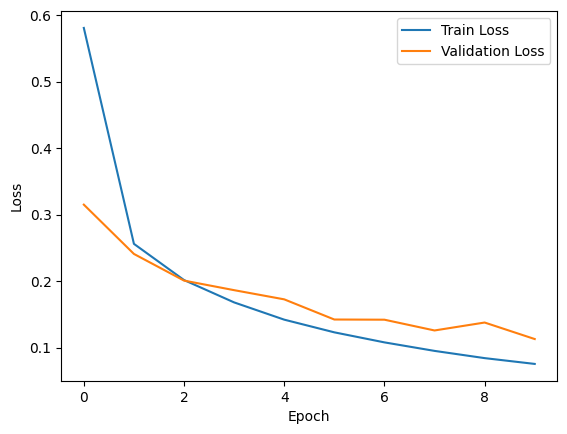

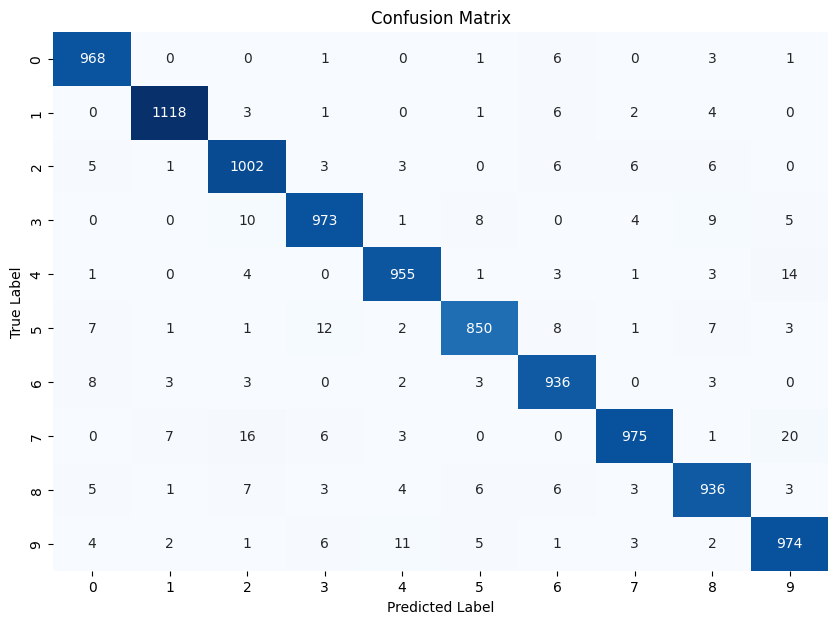

In [ ]:
model = MLP(activation='sigmoid').to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    train_loss, train_f1 = train(model, trainloader, optimizer_adam, criterion)
    val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {val_acc:.3f}.. "
          f"Train F1: {train_f1:.3f}.. "
          f"Val F1: {val_f1:.3f}")


test_accuracy, test_conf_matrix = test(model, testloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# List of class labels for MNIST
classes = [str(i) for i in range(10)]
plot_confusion_matrix(test_conf_matrix, classes)


Epoch 1/10.. Train loss: 0.418.. Val loss: 0.251.. Val accuracy: 0.924.. Train F1: 0.883.. Val F1: 0.924
Epoch 2/10.. Train loss: 0.205.. Val loss: 0.198.. Val accuracy: 0.942.. Train F1: 0.940.. Val F1: 0.942
Epoch 3/10.. Train loss: 0.157.. Val loss: 0.154.. Val accuracy: 0.955.. Train F1: 0.954.. Val F1: 0.955
Epoch 4/10.. Train loss: 0.128.. Val loss: 0.181.. Val accuracy: 0.944.. Train F1: 0.964.. Val F1: 0.944
Epoch 5/10.. Train loss: 0.112.. Val loss: 0.130.. Val accuracy: 0.961.. Train F1: 0.968.. Val F1: 0.961
Epoch 6/10.. Train loss: 0.098.. Val loss: 0.131.. Val accuracy: 0.960.. Train F1: 0.972.. Val F1: 0.960
Epoch 7/10.. Train loss: 0.087.. Val loss: 0.116.. Val accuracy: 0.965.. Train F1: 0.975.. Val F1: 0.965
Epoch 8/10.. Train loss: 0.080.. Val loss: 0.122.. Val accuracy: 0.964.. Train F1: 0.977.. Val F1: 0.964
Epoch 9/10.. Train loss: 0.077.. Val loss: 0.118.. Val accuracy: 0.964.. Train F1: 0.977.. Val F1: 0.964
Epoch 10/10.. Train loss: 0.071.. Val loss: 0.120.. Val

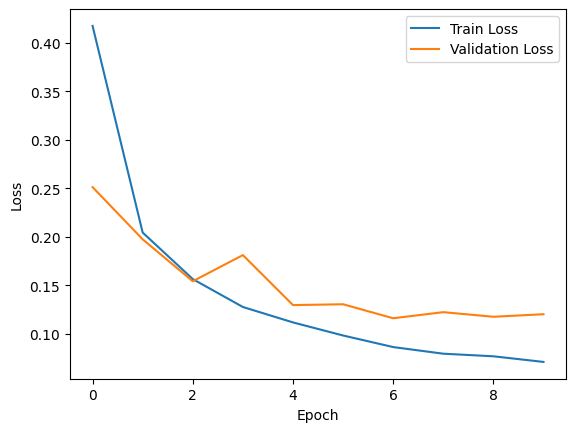

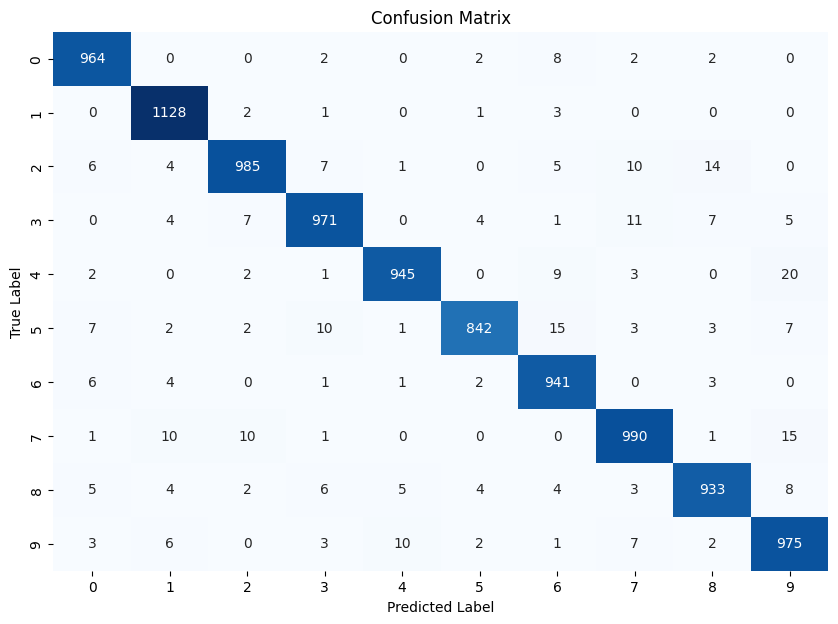

In [ ]:
model = MLP(activation='tanh').to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    train_loss, train_f1 = train(model, trainloader, optimizer_adam, criterion)
    val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {val_acc:.3f}.. "
          f"Train F1: {train_f1:.3f}.. "
          f"Val F1: {val_f1:.3f}")


test_accuracy, test_conf_matrix = test(model, testloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# List of class labels for MNIST
classes = [str(i) for i in range(10)]
plot_confusion_matrix(test_conf_matrix, classes)


# Question 4

Epoch 1/10.. Train loss: 0.453.. Val loss: 0.291.. Val accuracy: 0.912.. Train F1: 0.870.. Val F1: 0.912
Epoch 2/10.. Train loss: 0.240.. Val loss: 0.246.. Val accuracy: 0.926.. Train F1: 0.930.. Val F1: 0.926
Epoch 3/10.. Train loss: 0.174.. Val loss: 0.169.. Val accuracy: 0.950.. Train F1: 0.949.. Val F1: 0.950
Epoch 4/10.. Train loss: 0.140.. Val loss: 0.146.. Val accuracy: 0.955.. Train F1: 0.959.. Val F1: 0.955
Epoch 5/10.. Train loss: 0.118.. Val loss: 0.142.. Val accuracy: 0.957.. Train F1: 0.965.. Val F1: 0.957
Epoch 6/10.. Train loss: 0.100.. Val loss: 0.128.. Val accuracy: 0.962.. Train F1: 0.970.. Val F1: 0.962
Epoch 7/10.. Train loss: 0.089.. Val loss: 0.124.. Val accuracy: 0.963.. Train F1: 0.972.. Val F1: 0.963
Epoch 8/10.. Train loss: 0.079.. Val loss: 0.130.. Val accuracy: 0.959.. Train F1: 0.975.. Val F1: 0.959
Epoch 9/10.. Train loss: 0.071.. Val loss: 0.116.. Val accuracy: 0.964.. Train F1: 0.976.. Val F1: 0.965
Epoch 10/10.. Train loss: 0.064.. Val loss: 0.144.. Val

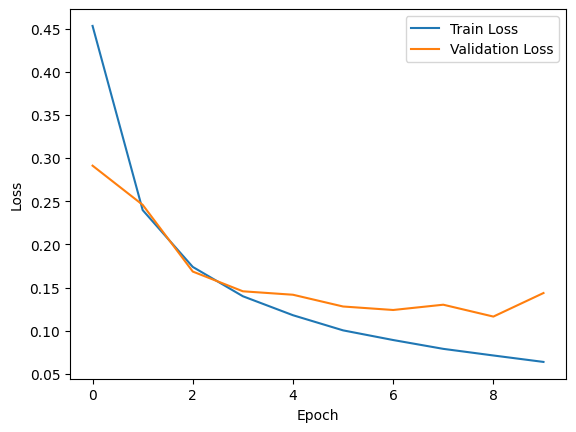

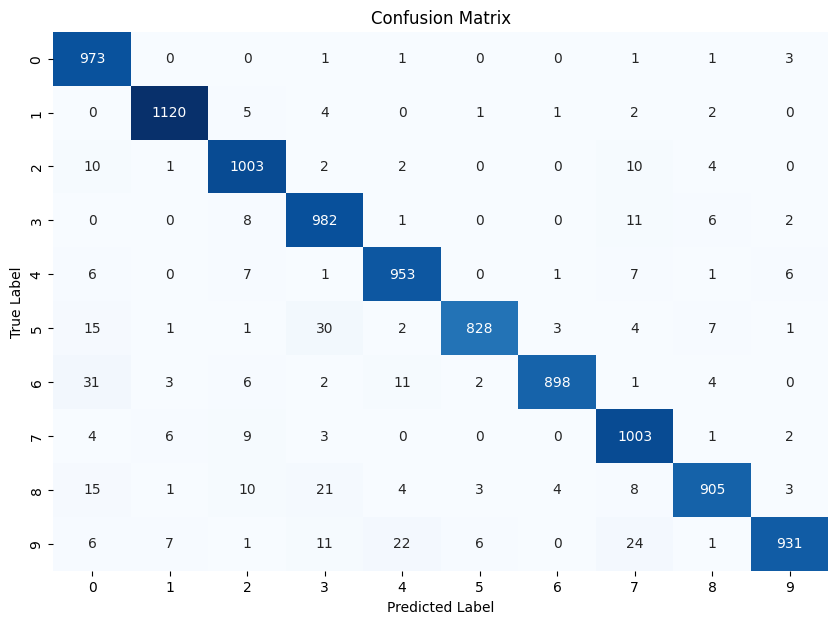

In [ ]:
model = MLP(activation='relu').to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    train_loss, train_f1 = train(model, trainloader, optimizer_adam, criterion)
    val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {val_acc:.3f}.. "
          f"Train F1: {train_f1:.3f}.. "
          f"Val F1: {val_f1:.3f}")


test_accuracy, test_conf_matrix = test(model, testloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# List of class labels for MNIST
classes = [str(i) for i in range(10)]
plot_confusion_matrix(test_conf_matrix, classes)


Epoch 1/10.. Train loss: 2.194.. Val loss: 2.044.. Val accuracy: 0.533.. Train F1: 0.264.. Val F1: 0.512
Epoch 2/10.. Train loss: 1.845.. Val loss: 1.630.. Val accuracy: 0.694.. Train F1: 0.605.. Val F1: 0.670
Epoch 3/10.. Train loss: 1.413.. Val loss: 1.220.. Val accuracy: 0.767.. Train F1: 0.723.. Val F1: 0.758
Epoch 4/10.. Train loss: 1.067.. Val loss: 0.948.. Val accuracy: 0.803.. Train F1: 0.788.. Val F1: 0.799
Epoch 5/10.. Train loss: 0.853.. Val loss: 0.785.. Val accuracy: 0.824.. Train F1: 0.818.. Val F1: 0.821
Epoch 6/10.. Train loss: 0.722.. Val loss: 0.683.. Val accuracy: 0.840.. Train F1: 0.836.. Val F1: 0.839
Epoch 7/10.. Train loss: 0.638.. Val loss: 0.615.. Val accuracy: 0.850.. Train F1: 0.848.. Val F1: 0.849
Epoch 8/10.. Train loss: 0.580.. Val loss: 0.566.. Val accuracy: 0.857.. Train F1: 0.856.. Val F1: 0.856
Epoch 9/10.. Train loss: 0.538.. Val loss: 0.530.. Val accuracy: 0.863.. Train F1: 0.863.. Val F1: 0.862
Epoch 10/10.. Train loss: 0.507.. Val loss: 0.503.. Val

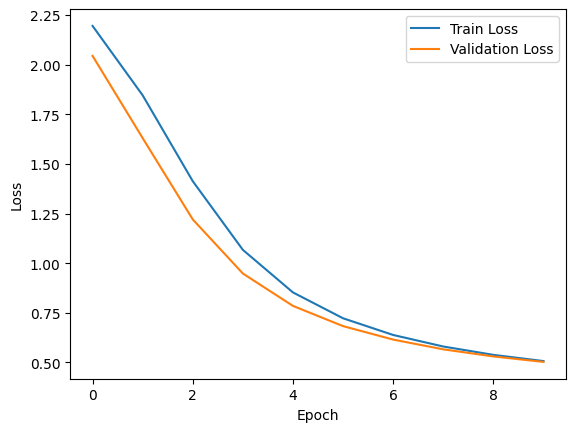

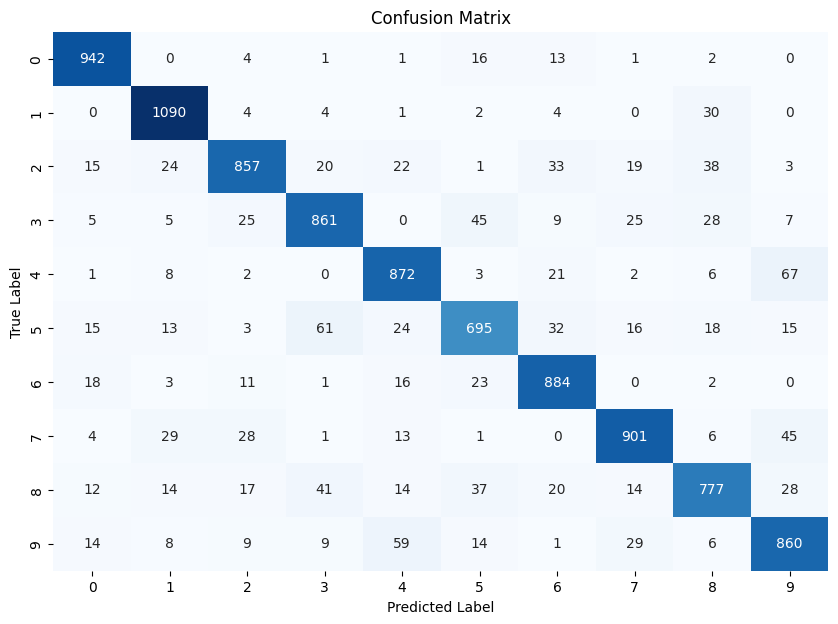

In [ ]:
model = MLP(activation='relu').to(device)
criterion = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(model.parameters(), lr=0.001)

epochs = 10
train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    train_loss, train_f1 = train(model, trainloader, optimizer_sgd, criterion)
    val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {val_acc:.3f}.. "
          f"Train F1: {train_f1:.3f}.. "
          f"Val F1: {val_f1:.3f}")


test_accuracy, test_conf_matrix = test(model, testloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# List of class labels for MNIST
classes = [str(i) for i in range(10)]
plot_confusion_matrix(test_conf_matrix, classes)


# Question 5

Epoch 1/10.. Train loss: 2.162.. Val loss: 2.005.. Val accuracy: 0.537.. Train F1: 0.327.. Val F1: 0.490
Epoch 2/10.. Train loss: 1.804.. Val loss: 1.593.. Val accuracy: 0.674.. Train F1: 0.585.. Val F1: 0.649
Epoch 3/10.. Train loss: 1.382.. Val loss: 1.198.. Val accuracy: 0.756.. Train F1: 0.706.. Val F1: 0.745
Epoch 4/10.. Train loss: 1.050.. Val loss: 0.936.. Val accuracy: 0.802.. Train F1: 0.778.. Val F1: 0.798
Epoch 5/10.. Train loss: 0.843.. Val loss: 0.779.. Val accuracy: 0.826.. Train F1: 0.813.. Val F1: 0.824
Epoch 6/10.. Train loss: 0.716.. Val loss: 0.677.. Val accuracy: 0.842.. Train F1: 0.834.. Val F1: 0.840
Epoch 7/10.. Train loss: 0.634.. Val loss: 0.610.. Val accuracy: 0.850.. Train F1: 0.848.. Val F1: 0.849
Epoch 8/10.. Train loss: 0.577.. Val loss: 0.562.. Val accuracy: 0.858.. Train F1: 0.856.. Val F1: 0.857
Epoch 9/10.. Train loss: 0.535.. Val loss: 0.526.. Val accuracy: 0.865.. Train F1: 0.863.. Val F1: 0.864
Epoch 10/10.. Train loss: 0.504.. Val loss: 0.499.. Val

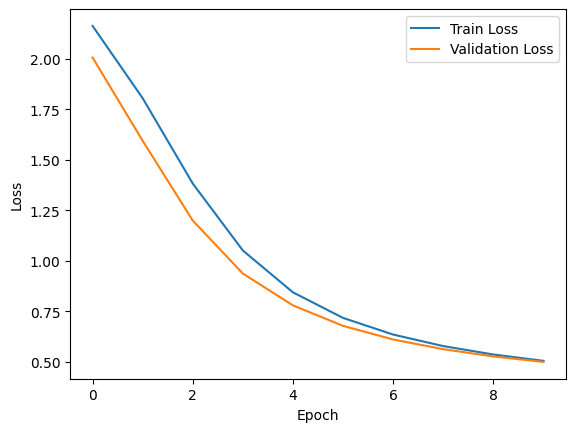

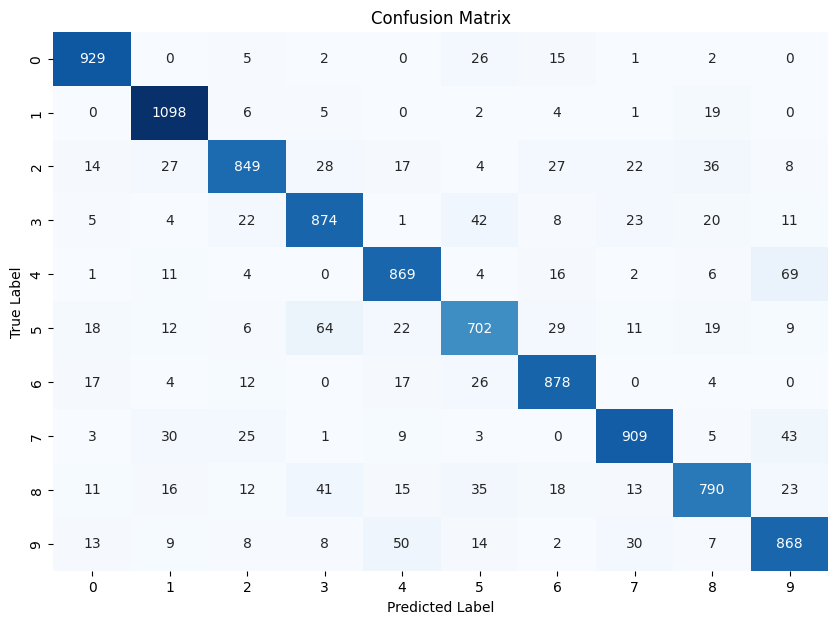

------------------------------------------------------------
Epoch 1/10.. Train loss: 1.412.. Val loss: 0.762.. Val accuracy: 0.826.. Train F1: 0.660.. Val F1: 0.823
Epoch 2/10.. Train loss: 0.588.. Val loss: 0.499.. Val accuracy: 0.866.. Train F1: 0.855.. Val F1: 0.865
Epoch 3/10.. Train loss: 0.449.. Val loss: 0.423.. Val accuracy: 0.882.. Train F1: 0.879.. Val F1: 0.881
Epoch 4/10.. Train loss: 0.396.. Val loss: 0.391.. Val accuracy: 0.888.. Train F1: 0.889.. Val F1: 0.887
Epoch 5/10.. Train loss: 0.367.. Val loss: 0.368.. Val accuracy: 0.892.. Train F1: 0.896.. Val F1: 0.892
Epoch 6/10.. Train loss: 0.348.. Val loss: 0.353.. Val accuracy: 0.898.. Train F1: 0.901.. Val F1: 0.898
Epoch 7/10.. Train loss: 0.334.. Val loss: 0.339.. Val accuracy: 0.901.. Train F1: 0.904.. Val F1: 0.901
Epoch 8/10.. Train loss: 0.324.. Val loss: 0.332.. Val accuracy: 0.903.. Train F1: 0.907.. Val F1: 0.902
Epoch 9/10.. Train loss: 0.314.. Val loss: 0.321.. Val accuracy: 0.906.. Train F1: 0.910.. Val F1: 

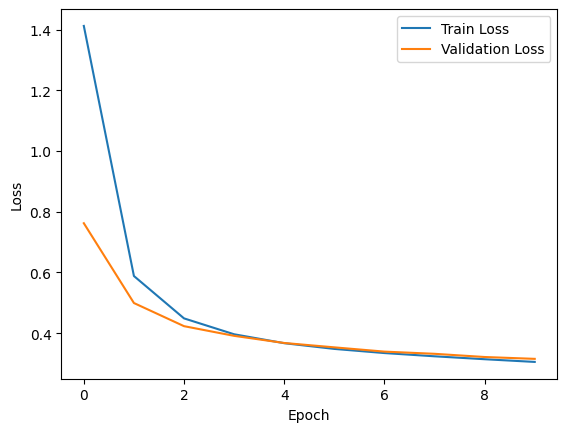

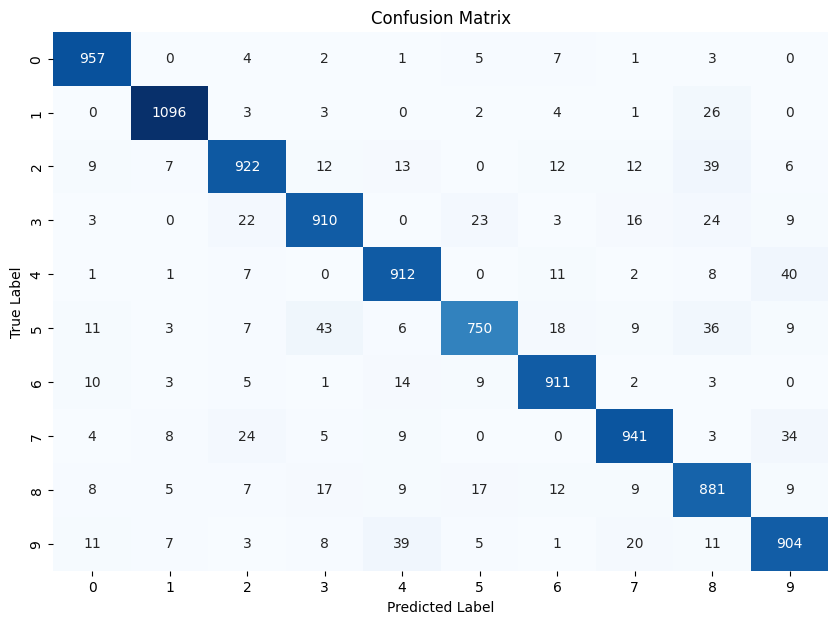

------------------------------------------------------------
Epoch 1/10.. Train loss: 1.036.. Val loss: 0.523.. Val accuracy: 0.855.. Train F1: 0.741.. Val F1: 0.854
Epoch 2/10.. Train loss: 0.433.. Val loss: 0.408.. Val accuracy: 0.882.. Train F1: 0.879.. Val F1: 0.881
Epoch 3/10.. Train loss: 0.362.. Val loss: 0.358.. Val accuracy: 0.894.. Train F1: 0.897.. Val F1: 0.894
Epoch 4/10.. Train loss: 0.331.. Val loss: 0.333.. Val accuracy: 0.901.. Train F1: 0.903.. Val F1: 0.901
Epoch 5/10.. Train loss: 0.308.. Val loss: 0.311.. Val accuracy: 0.908.. Train F1: 0.911.. Val F1: 0.908
Epoch 6/10.. Train loss: 0.292.. Val loss: 0.300.. Val accuracy: 0.912.. Train F1: 0.916.. Val F1: 0.912
Epoch 7/10.. Train loss: 0.278.. Val loss: 0.289.. Val accuracy: 0.918.. Train F1: 0.920.. Val F1: 0.918
Epoch 8/10.. Train loss: 0.265.. Val loss: 0.280.. Val accuracy: 0.916.. Train F1: 0.924.. Val F1: 0.916
Epoch 9/10.. Train loss: 0.253.. Val loss: 0.272.. Val accuracy: 0.919.. Train F1: 0.928.. Val F1: 

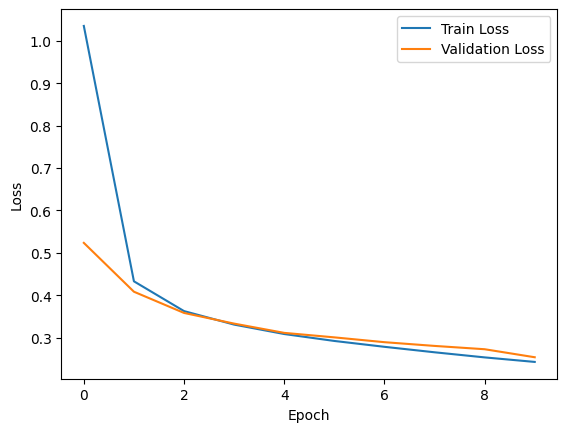

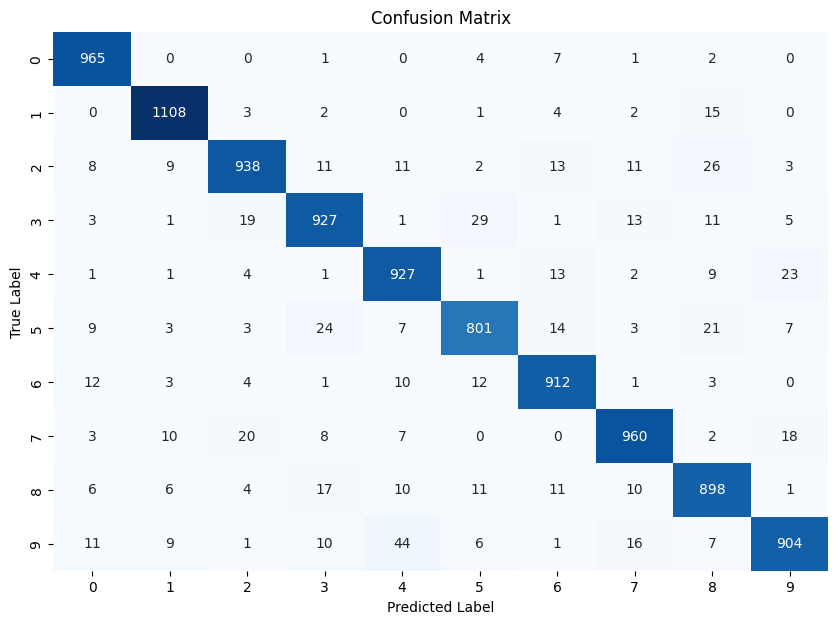

------------------------------------------------------------


In [ ]:
for learning_rate in [0.001, 0.005, 0.01]:
    model = MLP(activation='relu').to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_sgd = optim.SGD(model.parameters(), lr=learning_rate)

    epochs = 10
    train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

    for epoch in range(epochs):
        train_loss, train_f1 = train(model, trainloader, optimizer_sgd, criterion)
        val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {train_loss:.3f}.. "
              f"Val loss: {val_loss:.3f}.. "
              f"Val accuracy: {val_acc:.3f}.. "
              f"Train F1: {train_f1:.3f}.. "
              f"Val F1: {val_f1:.3f}")


    test_accuracy, test_conf_matrix = test(model, testloader)
    print(f'Test Accuracy: {test_accuracy:.3f}')

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # List of class labels for MNIST
    classes = [str(i) for i in range(10)]
    plot_confusion_matrix(test_conf_matrix, classes)

    print('------------------------------------------------------------')

# Question 6

Epoch 1/10.. Train loss: 0.453.. Val loss: 0.305.. Val accuracy: 0.906.. Train F1: 0.867.. Val F1: 0.906
Epoch 2/10.. Train loss: 0.244.. Val loss: 0.209.. Val accuracy: 0.939.. Train F1: 0.930.. Val F1: 0.938
Epoch 3/10.. Train loss: 0.178.. Val loss: 0.188.. Val accuracy: 0.943.. Train F1: 0.949.. Val F1: 0.943
Epoch 4/10.. Train loss: 0.141.. Val loss: 0.150.. Val accuracy: 0.955.. Train F1: 0.958.. Val F1: 0.955
Epoch 5/10.. Train loss: 0.118.. Val loss: 0.138.. Val accuracy: 0.958.. Train F1: 0.965.. Val F1: 0.958
Epoch 6/10.. Train loss: 0.099.. Val loss: 0.113.. Val accuracy: 0.966.. Train F1: 0.971.. Val F1: 0.966
Epoch 7/10.. Train loss: 0.089.. Val loss: 0.118.. Val accuracy: 0.964.. Train F1: 0.973.. Val F1: 0.964
Epoch 8/10.. Train loss: 0.079.. Val loss: 0.125.. Val accuracy: 0.963.. Train F1: 0.975.. Val F1: 0.963
Epoch 9/10.. Train loss: 0.070.. Val loss: 0.113.. Val accuracy: 0.966.. Train F1: 0.978.. Val F1: 0.966
Epoch 10/10.. Train loss: 0.064.. Val loss: 0.100.. Val

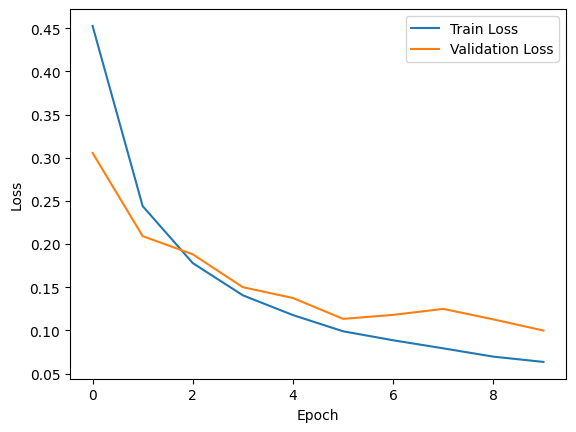

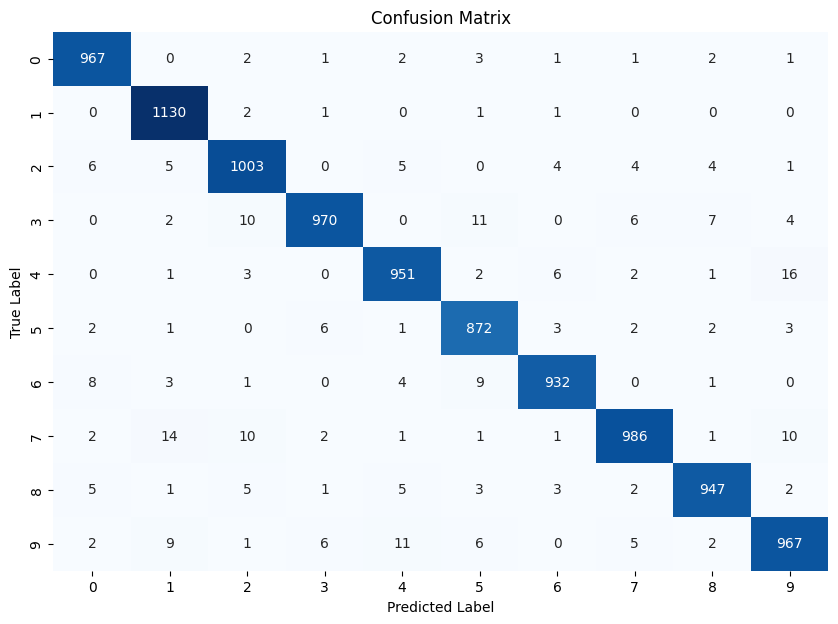

------------------------------------------------------------


In [ ]:
model = MLP(init_method=None).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    train_loss, train_f1 = train(model, trainloader, optimizer_adam, criterion)
    val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {val_acc:.3f}.. "
          f"Train F1: {train_f1:.3f}.. "
          f"Val F1: {val_f1:.3f}")


test_accuracy, test_conf_matrix = test(model, testloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# List of class labels for MNIST
classes = [str(i) for i in range(10)]
plot_confusion_matrix(test_conf_matrix, classes)



Epoch 1/10.. Train loss: 0.395.. Val loss: 0.257.. Val accuracy: 0.923.. Train F1: 0.880.. Val F1: 0.923
Epoch 2/10.. Train loss: 0.208.. Val loss: 0.210.. Val accuracy: 0.936.. Train F1: 0.938.. Val F1: 0.936
Epoch 3/10.. Train loss: 0.156.. Val loss: 0.171.. Val accuracy: 0.946.. Train F1: 0.954.. Val F1: 0.947
Epoch 4/10.. Train loss: 0.123.. Val loss: 0.151.. Val accuracy: 0.955.. Train F1: 0.964.. Val F1: 0.955
Epoch 5/10.. Train loss: 0.107.. Val loss: 0.127.. Val accuracy: 0.960.. Train F1: 0.968.. Val F1: 0.960
Epoch 6/10.. Train loss: 0.093.. Val loss: 0.128.. Val accuracy: 0.960.. Train F1: 0.972.. Val F1: 0.960
Epoch 7/10.. Train loss: 0.080.. Val loss: 0.132.. Val accuracy: 0.959.. Train F1: 0.975.. Val F1: 0.960
Epoch 8/10.. Train loss: 0.071.. Val loss: 0.109.. Val accuracy: 0.966.. Train F1: 0.977.. Val F1: 0.966
Epoch 9/10.. Train loss: 0.064.. Val loss: 0.112.. Val accuracy: 0.967.. Train F1: 0.980.. Val F1: 0.967
Epoch 10/10.. Train loss: 0.059.. Val loss: 0.113.. Val

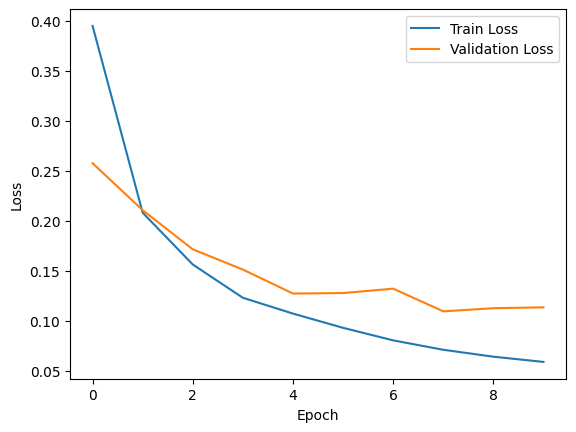

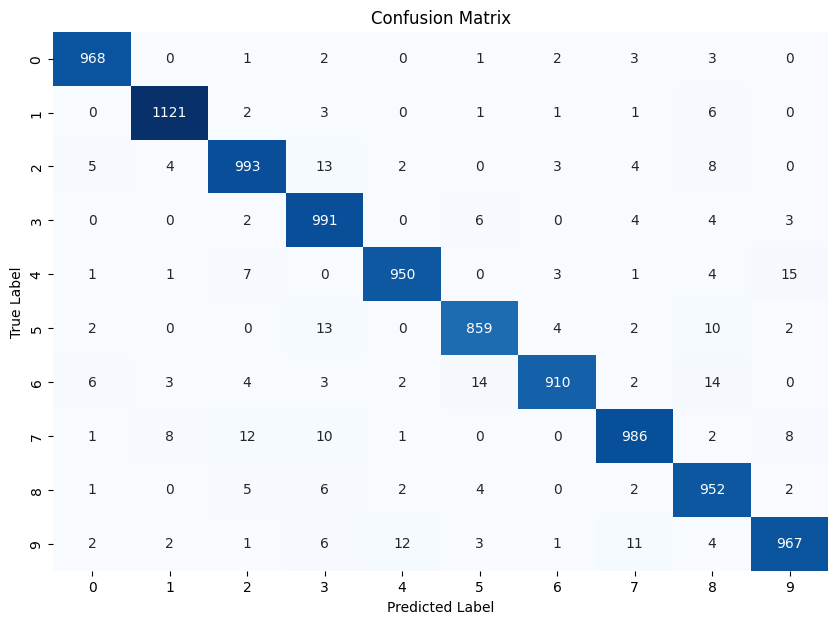

------------------------------------------------------------


In [ ]:
model = MLP(init_method='xavier').to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    train_loss, train_f1 = train(model, trainloader, optimizer_adam, criterion)
    val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {val_acc:.3f}.. "
          f"Train F1: {train_f1:.3f}.. "
          f"Val F1: {val_f1:.3f}")


test_accuracy, test_conf_matrix = test(model, testloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# List of class labels for MNIST
classes = [str(i) for i in range(10)]
plot_confusion_matrix(test_conf_matrix, classes)



Epoch 1/10.. Train loss: 0.386.. Val loss: 0.274.. Val accuracy: 0.918.. Train F1: 0.883.. Val F1: 0.919
Epoch 2/10.. Train loss: 0.200.. Val loss: 0.171.. Val accuracy: 0.948.. Train F1: 0.940.. Val F1: 0.948
Epoch 3/10.. Train loss: 0.149.. Val loss: 0.158.. Val accuracy: 0.952.. Train F1: 0.956.. Val F1: 0.952
Epoch 4/10.. Train loss: 0.121.. Val loss: 0.142.. Val accuracy: 0.958.. Train F1: 0.964.. Val F1: 0.958
Epoch 5/10.. Train loss: 0.103.. Val loss: 0.140.. Val accuracy: 0.958.. Train F1: 0.969.. Val F1: 0.958
Epoch 6/10.. Train loss: 0.087.. Val loss: 0.130.. Val accuracy: 0.961.. Train F1: 0.973.. Val F1: 0.961
Epoch 7/10.. Train loss: 0.081.. Val loss: 0.118.. Val accuracy: 0.965.. Train F1: 0.975.. Val F1: 0.965
Epoch 8/10.. Train loss: 0.071.. Val loss: 0.126.. Val accuracy: 0.963.. Train F1: 0.977.. Val F1: 0.963
Epoch 9/10.. Train loss: 0.064.. Val loss: 0.105.. Val accuracy: 0.969.. Train F1: 0.980.. Val F1: 0.969
Epoch 10/10.. Train loss: 0.058.. Val loss: 0.111.. Val

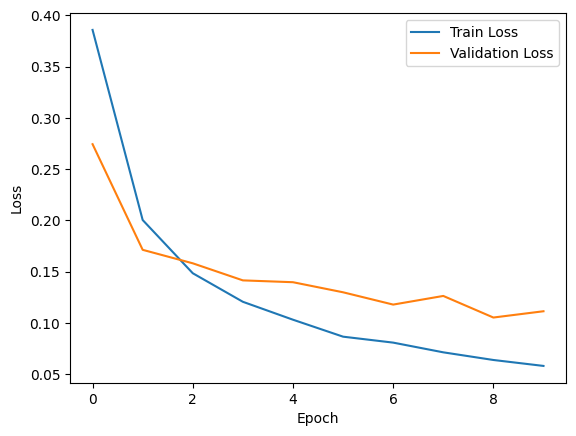

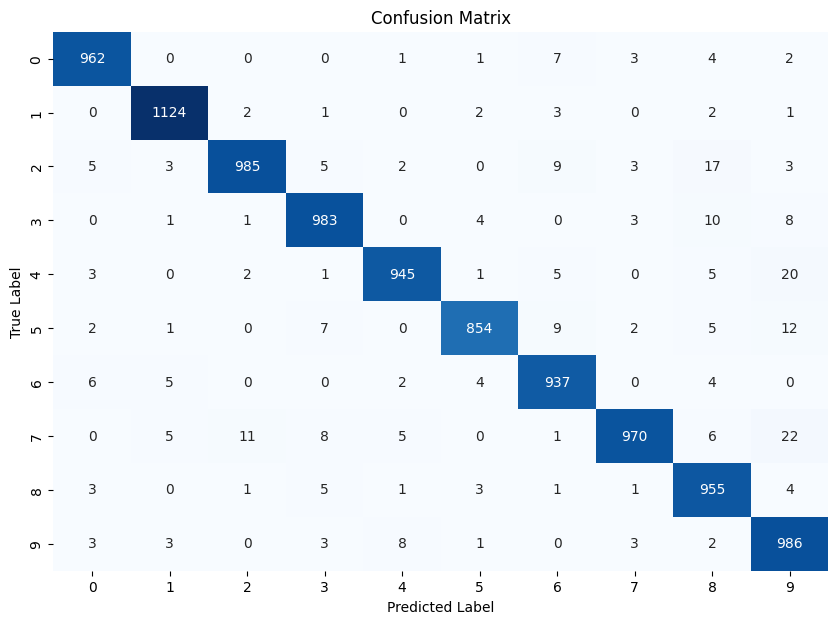

In [ ]:
model = MLP(init_method='he').to(device)
criterion = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

for epoch in range(epochs):
    train_loss, train_f1 = train(model, trainloader, optimizer_adam, criterion)
    val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    print(f"Epoch {epoch+1}/{epochs}.. "
          f"Train loss: {train_loss:.3f}.. "
          f"Val loss: {val_loss:.3f}.. "
          f"Val accuracy: {val_acc:.3f}.. "
          f"Train F1: {train_f1:.3f}.. "
          f"Val F1: {val_f1:.3f}")


test_accuracy, test_conf_matrix = test(model, testloader)
print(f'Test Accuracy: {test_accuracy:.3f}')

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# List of class labels for MNIST
classes = [str(i) for i in range(10)]
plot_confusion_matrix(test_conf_matrix, classes)


# Question 7

In [ ]:
class MLP7(nn.Module):
    def __init__(self, activation='relu', init_method=None, dropout_rate=0.5, input_size=28*28, hidden_size=128, output_size=10):
        super(MLP7, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)  # Dropout layer

        # Weight initialization
        if init_method == 'xavier':
            nn.init.xavier_uniform_(self.fc1.weight)
            nn.init.xavier_uniform_(self.fc2.weight)
        elif init_method == 'he':
            nn.init.kaiming_uniform_(self.fc1.weight, nonlinearity='relu')
            nn.init.kaiming_uniform_(self.fc2.weight, nonlinearity='relu')
        else:
            nn.init.uniform_(self.fc1.weight, -0.05, 0.05)
            nn.init.uniform_(self.fc2.weight, -0.05, 0.05)

        # Activation function
        if activation == 'relu':
            self.activation = F.relu
        elif activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'sigmoid':
            self.activation = torch.sigmoid

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.activation(self.fc1(x))
        x = self.dropout(x)  # Apply dropout after activation
        x = self.fc2(x)  # No activation for output layer since we use CrossEntropyLoss
        return x


Running Question 7 with Dropout Rate: 0.2
Epoch 1/10.. Train loss: 0.477.. Val loss: 0.269.. Val accuracy: 0.920.. Train F1: 0.858.. Val F1: 0.919
Epoch 2/10.. Train loss: 0.245.. Val loss: 0.187.. Val accuracy: 0.945.. Train F1: 0.927.. Val F1: 0.945
Epoch 3/10.. Train loss: 0.197.. Val loss: 0.152.. Val accuracy: 0.953.. Train F1: 0.940.. Val F1: 0.953
Epoch 4/10.. Train loss: 0.167.. Val loss: 0.141.. Val accuracy: 0.957.. Train F1: 0.950.. Val F1: 0.957
Epoch 5/10.. Train loss: 0.151.. Val loss: 0.134.. Val accuracy: 0.959.. Train F1: 0.954.. Val F1: 0.959
Epoch 6/10.. Train loss: 0.135.. Val loss: 0.130.. Val accuracy: 0.961.. Train F1: 0.958.. Val F1: 0.960
Epoch 7/10.. Train loss: 0.124.. Val loss: 0.113.. Val accuracy: 0.967.. Train F1: 0.961.. Val F1: 0.967
Epoch 8/10.. Train loss: 0.117.. Val loss: 0.110.. Val accuracy: 0.967.. Train F1: 0.965.. Val F1: 0.967
Epoch 9/10.. Train loss: 0.109.. Val loss: 0.107.. Val accuracy: 0.968.. Train F1: 0.966.. Val F1: 0.968
Epoch 10/10..

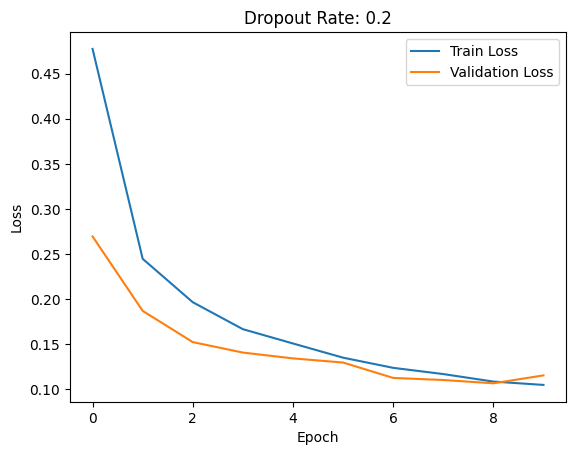

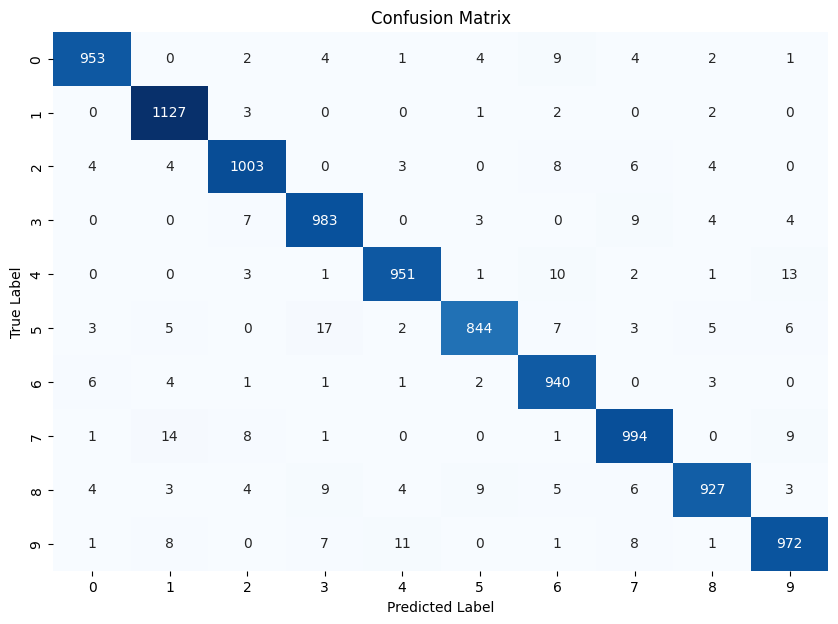

Running Question 7 with Dropout Rate: 0.5
Epoch 1/10.. Train loss: 0.625.. Val loss: 0.302.. Val accuracy: 0.907.. Train F1: 0.809.. Val F1: 0.907
Epoch 2/10.. Train loss: 0.378.. Val loss: 0.234.. Val accuracy: 0.929.. Train F1: 0.886.. Val F1: 0.929
Epoch 3/10.. Train loss: 0.322.. Val loss: 0.206.. Val accuracy: 0.940.. Train F1: 0.903.. Val F1: 0.940
Epoch 4/10.. Train loss: 0.299.. Val loss: 0.193.. Val accuracy: 0.941.. Train F1: 0.911.. Val F1: 0.941
Epoch 5/10.. Train loss: 0.285.. Val loss: 0.176.. Val accuracy: 0.947.. Train F1: 0.914.. Val F1: 0.947
Epoch 6/10.. Train loss: 0.270.. Val loss: 0.170.. Val accuracy: 0.949.. Train F1: 0.918.. Val F1: 0.949
Epoch 7/10.. Train loss: 0.259.. Val loss: 0.166.. Val accuracy: 0.951.. Train F1: 0.920.. Val F1: 0.951
Epoch 8/10.. Train loss: 0.252.. Val loss: 0.155.. Val accuracy: 0.954.. Train F1: 0.923.. Val F1: 0.954
Epoch 9/10.. Train loss: 0.245.. Val loss: 0.142.. Val accuracy: 0.957.. Train F1: 0.925.. Val F1: 0.957
Epoch 10/10..

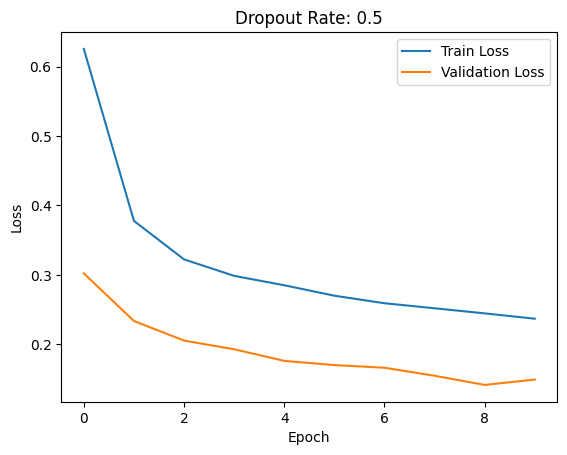

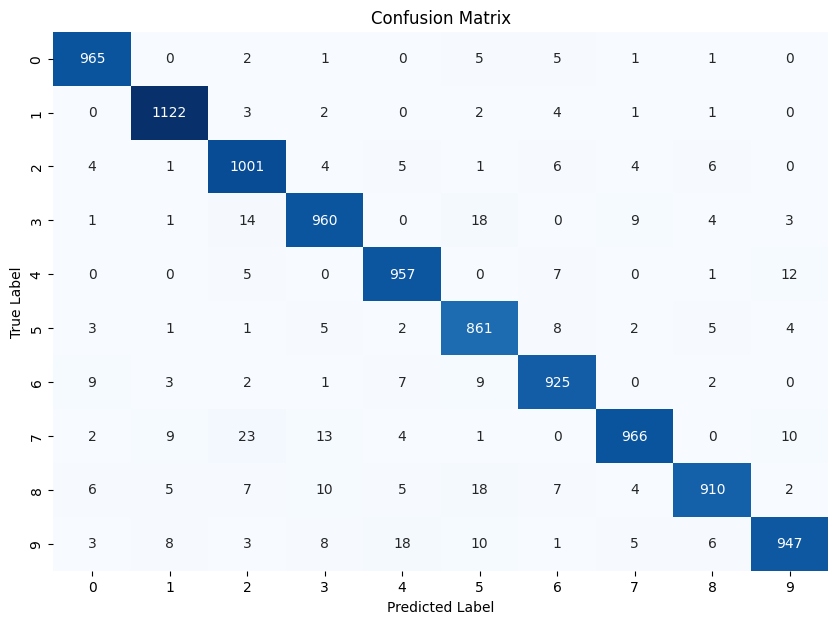

Running Question 7 with Dropout Rate: 0.7
Epoch 1/10.. Train loss: 0.827.. Val loss: 0.370.. Val accuracy: 0.896.. Train F1: 0.734.. Val F1: 0.895
Epoch 2/10.. Train loss: 0.573.. Val loss: 0.310.. Val accuracy: 0.911.. Train F1: 0.819.. Val F1: 0.911
Epoch 3/10.. Train loss: 0.532.. Val loss: 0.271.. Val accuracy: 0.920.. Train F1: 0.833.. Val F1: 0.920
Epoch 4/10.. Train loss: 0.508.. Val loss: 0.251.. Val accuracy: 0.924.. Train F1: 0.838.. Val F1: 0.924
Epoch 5/10.. Train loss: 0.489.. Val loss: 0.246.. Val accuracy: 0.927.. Train F1: 0.843.. Val F1: 0.927
Epoch 6/10.. Train loss: 0.469.. Val loss: 0.233.. Val accuracy: 0.933.. Train F1: 0.850.. Val F1: 0.933
Epoch 7/10.. Train loss: 0.467.. Val loss: 0.224.. Val accuracy: 0.934.. Train F1: 0.850.. Val F1: 0.934
Epoch 8/10.. Train loss: 0.458.. Val loss: 0.219.. Val accuracy: 0.935.. Train F1: 0.852.. Val F1: 0.935
Epoch 9/10.. Train loss: 0.450.. Val loss: 0.213.. Val accuracy: 0.935.. Train F1: 0.856.. Val F1: 0.935
Epoch 10/10..

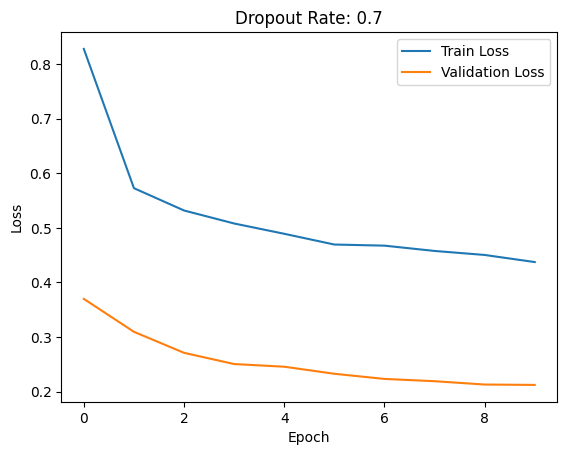

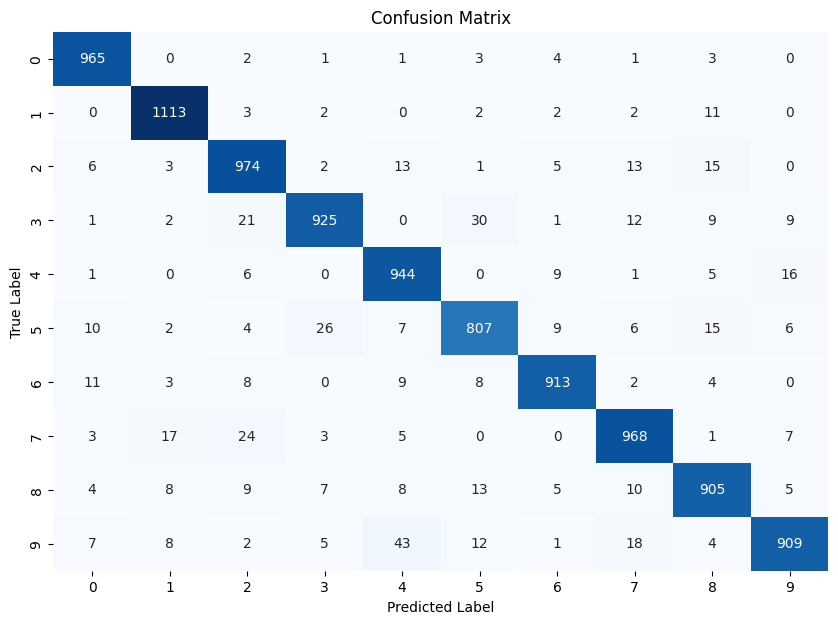

In [ ]:
# Function to train and validate the model
def run_experiment(dropout_rate):
    print(f'Running Question 7 with Dropout Rate: {dropout_rate}')
    model = MLP7(init_method=None, dropout_rate=dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer_adam = optim.Adam(model.parameters(), lr=0.001)

    epochs = 10
    train_losses, val_losses, val_accuracies, train_f1_scores, val_f1_scores = [], [], [], [], []

    for epoch in range(epochs):
        train_loss, train_f1 = train(model, trainloader, optimizer_adam, criterion)
        val_loss, val_acc, val_f1 = validate(model, valloader, criterion)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        print(f"Epoch {epoch+1}/{epochs}.. "
              f"Train loss: {train_loss:.3f}.. "
              f"Val loss: {val_loss:.3f}.. "
              f"Val accuracy: {val_acc:.3f}.. "
              f"Train F1: {train_f1:.3f}.. "
              f"Val F1: {val_f1:.3f}")

    test_accuracy, test_conf_matrix = test(model, testloader)
    print(f'Test Accuracy: {test_accuracy:.3f}')

    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(f'Dropout Rate: {dropout_rate}')
    plt.show()

    # List of class labels for MNIST
    classes = [str(i) for i in range(10)]
    plot_confusion_matrix(test_conf_matrix, classes)

# Test different dropout rates
for dropout in [0.2, 0.5, 0.7]:
    run_experiment(dropout)
